In [1]:
import sys
sys.path.insert(0, '../beats/')

In [2]:
import torch
import librosa
import torchaudio.functional as F
from BEATs import BEATs, BEATsConfig
from IPython.display import display, Audio
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
# load the fine-tuned checkpoints
checkpoint = torch.load('./BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt')

cfg = BEATsConfig(checkpoint['cfg'])
BEATs_model = BEATs(cfg)
BEATs_model.load_state_dict(checkpoint['model'])
BEATs_model.eval()
BEATs_model = BEATs_model.cuda()

SSL for audio, non only speeh, with random proje
https://github.com/microsoft/unilm/tree/master/beats

In [4]:
class_id_to_text_label = {'/m/04rlf': 'Music',
                          '/m/09x0r': 'Speech'
                         }

In [5]:
audio_path = '/home/taras/data/mls_spanish/dev/audio/10367/10282/10367_10282_000002.flac'
audio_path = '/data/podcasts/El hilo/La-ultima-clinica-de-aborto-en-la-frontera-sur-de-Texas.mp3'
# audio_path = '/data/podcasts/Inteligencia Artificial - Humana/IA-H-Carlos-Barrabes-2.mp3'

In [6]:
wav, sr = librosa.load(audio_path, sr=None, offset=60, duration=180)
model_sr = 16000
if sr != model_sr:
    wav = F.resample(torch.tensor(wav), sr, model_sr)
Audio(wav, rate=model_sr)

/home/taras/git-repos/one-lang/venv/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [7]:
with torch.no_grad():
    all_cls_probs = []
    all_probs = []
    all_labels = []
    for chunk in wav.split(model_sr // 2):
        chunk = chunk.unsqueeze(0).cuda()
        chunk_mask = torch.zeros_like(chunk)
        probs = BEATs_model.extract_features(chunk, padding_mask=chunk_mask)[0].cpu()
        chunk_probs, chunk_labels = probs.topk(k=5)
        all_cls_probs.append(probs)
        all_probs.append(chunk_probs)
        all_labels.append(chunk_labels)
all_cls_probs = torch.cat(all_cls_probs, dim=0)
# all_cls_probs = all_cls_probs.repeat_interleave(model_sr // 2, dim=0)

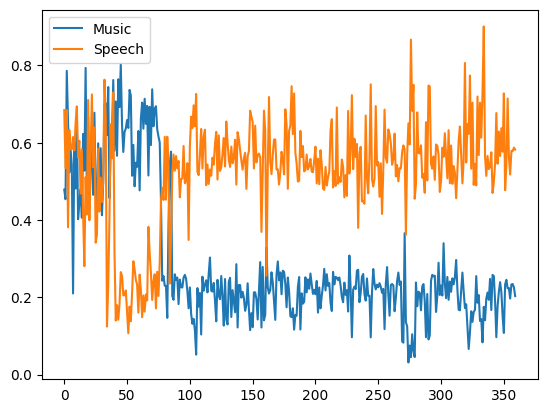

In [8]:
plt.plot(all_cls_probs[:, 2], label=class_id_to_text_label[checkpoint['label_dict'][2]])
plt.plot(all_cls_probs[:, 20], label=class_id_to_text_label[checkpoint['label_dict'][20]])
plt.legend()
plt.show()

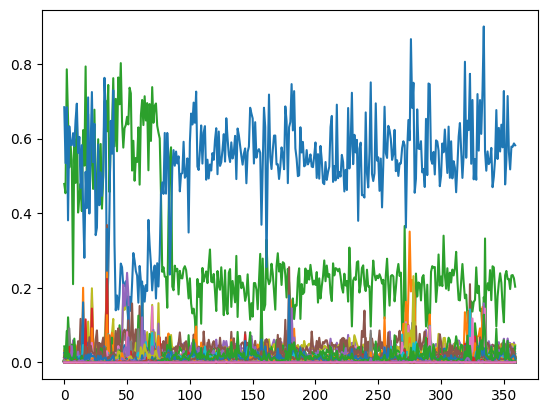

In [9]:
plt.plot(all_cls_probs)
plt.show()